In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# relative imports
from uncertainty_aware_diagnosis import (
    ICD10data,
    SimpleMLP,
    sklearnMLP,
)

# absolute imports
from torch.utils.data import DataLoader
from torch import nn
import torch
import numpy as np
from torchmetrics import F1Score, Recall, Accuracy

# paths
train_csv = "./data/train.csv"
val_csv = "./data/val.csv"
test_csv = "./data/test.csv"

In [3]:
# variables
batch_size = 32
hidden_dim = 256
shuffle = True

num_epochs = 10
early_stopping_patience = 5
dropout = 0.2
learning_rate = 1e-3
scheduler_step_size = 5
scheduler_gamma = 0.5

In [4]:
# load data
ds_train = ICD10data(train_csv)
ds_val = ICD10data(val_csv)
ds_test = ICD10data(test_csv)

train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=shuffle)
val_loader = DataLoader(ds_val, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=shuffle)

input_dim = ds_train.X.shape[1]
output_dim = ds_train.classes.shape[0]

print(f"(input_dim: {input_dim}, hidden_dim: {hidden_dim}, output_dim: {output_dim})")

(input_dim: 108, hidden_dim: 256, output_dim: 6)


In [5]:
# define model
model = SimpleMLP(
    input_dim=input_dim, hidden_dim=hidden_dim, num_classes=output_dim, dropout=dropout
)
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer,
#     step_size=scheduler_step_size,
#     gamma=scheduler_gamma
# )
# metrics
f1_macro = F1Score(task="multiclass", average="macro", num_classes=output_dim)
recall_macro = Recall(task="multiclass", average="macro", num_classes=output_dim)

# counters
best_f1 = -np.inf
epochs_no_improve = 0

for epoch in range(num_epochs):
    # training loop
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
    avg_train_loss = running_loss / len(train_loader.dataset)

    # validation loop
    model.eval()
    val_loss = 0.0
    f1_macro.reset()
    recall_macro.reset()
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(val_loader):
            logits = model(X)
            val_loss += criterion(logits, y).item() * X.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)

    # calculate metrics
    y_pred = torch.argmax(logits, dim=1)
    f1_macro.update(y_pred, y)
    recall_macro.update(y_pred, y)

    # print progress
    print(
        f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, F1 Macro: {f1_macro.compute():.4f}, Recall Macro: {recall_macro.compute():.4f}"
    )

    # Step the learning rate scheduler
    # scheduler.step()  # (If using ReduceLROnPlateau: scheduler.step(val_macro_f1))

    # check for improvement for early stopping
    if f1_macro.compute() > best_f1:
        best_f1 = f1_macro.compute()
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break


if "best_model_state" in locals():
    # load best model
    model.load_state_dict(best_model_state)
    # save best model
    # torch.save(best_model_state, 'models/best_model.pth')

print(
    "=================================================================================\n"
)
print(f"Best F1 Macro: {best_f1:.4f}, Recall Macro: {recall_macro.compute():.4f}")

Epoch 1/10, Train Loss: 1.5705, Val Loss: 1.5079, F1 Macro: 0.5654, Recall Macro: 0.5754
Epoch 2/10, Train Loss: 1.5260, Val Loss: 1.5027, F1 Macro: 0.5841, Recall Macro: 0.5952
Epoch 3/10, Train Loss: 1.5194, Val Loss: 1.5058, F1 Macro: 0.4225, Recall Macro: 0.4937
Epoch 4/10, Train Loss: 1.5145, Val Loss: 1.5029, F1 Macro: 0.3889, Recall Macro: 0.4167
Epoch 5/10, Train Loss: 1.5122, Val Loss: 1.5072, F1 Macro: 0.5363, Recall Macro: 0.5520
Epoch 6/10, Train Loss: 1.5106, Val Loss: 1.5056, F1 Macro: 0.2680, Recall Macro: 0.3275
Epoch 7/10, Train Loss: 1.5085, Val Loss: 1.5022, F1 Macro: 0.4818, Recall Macro: 0.4492
Early stopping triggered at epoch 7

Best F1 Macro: 0.5841, Recall Macro: 0.4492


In [6]:
# test best model
model.eval()
test_loss = 0.0
f1_macro.reset()
recall_macro.reset()
accuracy = Accuracy(task="multiclass", average="macro", num_classes=output_dim)

# Prepare a list to store predictions
predicted_probs = []

with torch.no_grad():
    for batch_idx, (X, y) in enumerate(test_loader):
        logits = model(X)
        loss = criterion(logits, y)
        test_loss += loss.item() * X.size(0)
        y_pred = torch.argmax(logits, dim=1)
        predicted_probs.append(logits)
        f1_macro.update(y_pred, y)
        recall_macro.update(y_pred, y)
        accuracy.update(y_pred, y)

# compute final values
test_acc = accuracy.compute()
test_f1 = f1_macro.compute()
test_recall = recall_macro.compute()
test_probs = torch.cat(predicted_probs)

print(f"Test Accuracy:          {test_acc:.4f}")
print(f"Test Macro-F1:          {test_f1:.4f}")
print(f"Test Macro-Recall:      {test_recall:.4f}")

Test Accuracy:          0.4286
Test Macro-F1:          0.4302
Test Macro-Recall:      0.4286


# Calibration

In [28]:
# Calibration imports
from pycalib.visualisations import plot_reliability_diagram
from sklearn.calibration import CalibratedClassifierCV
from pycalib.models.calibrators import LogisticCalibration
from pycalib.metrics import ECE, classwise_ECE, conf_ECE
from sklearn.preprocessing import label_binarize

In [14]:
X_train = ds_train.X.cpu().numpy()
y_train = ds_train.y.cpu().numpy()
X_val = ds_val.X.cpu().numpy()
y_val = ds_val.y.cpu().numpy()
X_test = ds_test.X.cpu().numpy()
y_test = ds_test.y.cpu().numpy()

In [12]:
# variables
num_epochs = 10
early_stopping_patience = 5
learn_rate = 1e-3
dropout = 0.2
hidden_dim = 256

model = SimpleMLP(
    input_dim=input_dim, hidden_dim=hidden_dim, num_classes=output_dim, dropout=dropout
)
model.fit(
    train_loader,
    val_loader,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    early_stopping_patience=early_stopping_patience,
    verbose=True,
)

y_pred = model.predict(ds_test.X)
y_proba = model.predict_proba(ds_test.X)

Epoch 1/10, Train Loss: 1.5627, Val Loss: 1.5119, F1 Macro: 0.4292, Recall Macro: 0.4295
Epoch 2/10, Train Loss: 1.5241, Val Loss: 1.5068, F1 Macro: 0.4349, Recall Macro: 0.4324
Epoch 3/10, Train Loss: 1.5190, Val Loss: 1.5090, F1 Macro: 0.4305, Recall Macro: 0.4286
Epoch 4/10, Train Loss: 1.5114, Val Loss: 1.5076, F1 Macro: 0.4339, Recall Macro: 0.4340
Epoch 5/10, Train Loss: 1.5095, Val Loss: 1.5076, F1 Macro: 0.4338, Recall Macro: 0.4332
Epoch 6/10, Train Loss: 1.5089, Val Loss: 1.5048, F1 Macro: 0.4332, Recall Macro: 0.4291
Epoch 7/10, Train Loss: 1.5079, Val Loss: 1.5064, F1 Macro: 0.4318, Recall Macro: 0.4311
Early stopping triggered at epoch 7

Best F1 Macro: 0.4318, Recall Macro: 0.4311


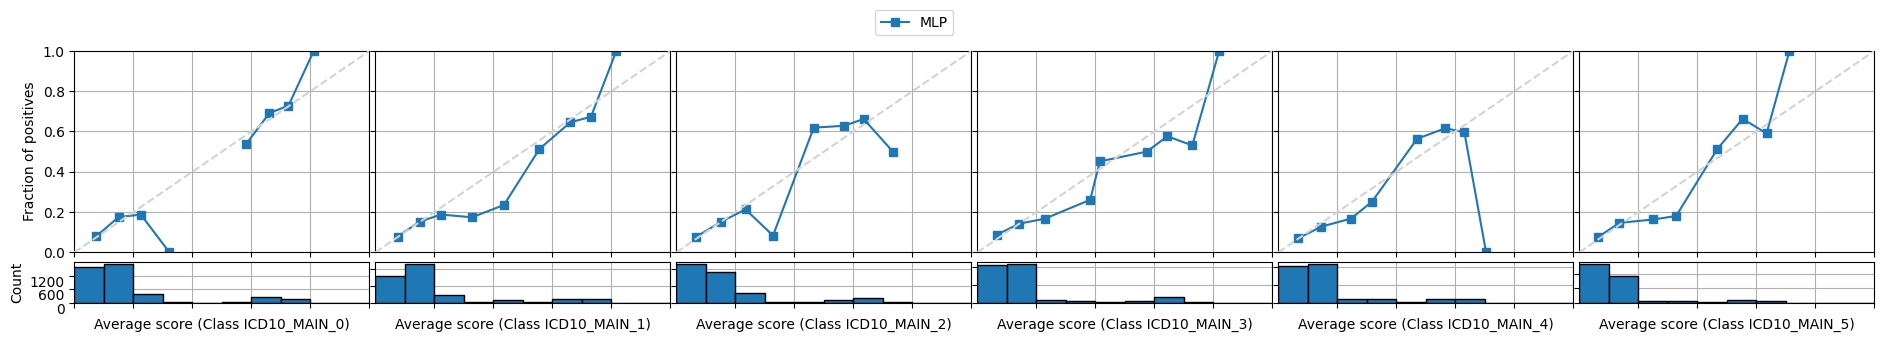

In [18]:
_ = plot_reliability_diagram(
    y_test,
    [
        y_proba,
    ],
    legend=[
        "MLP",
    ],
    class_names=list(ds_test.classes),
)

c:\Users\Lwsja\GitHub\uncertainty-aware-diagnosis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


ECE
Classifier = 0.018
Calibrator = 0.015

conf_ECE
Classifier = 0.043
Calibrator = 0.041

classwise_ECE
Classifier = 0.023
Calibrator = 0.019



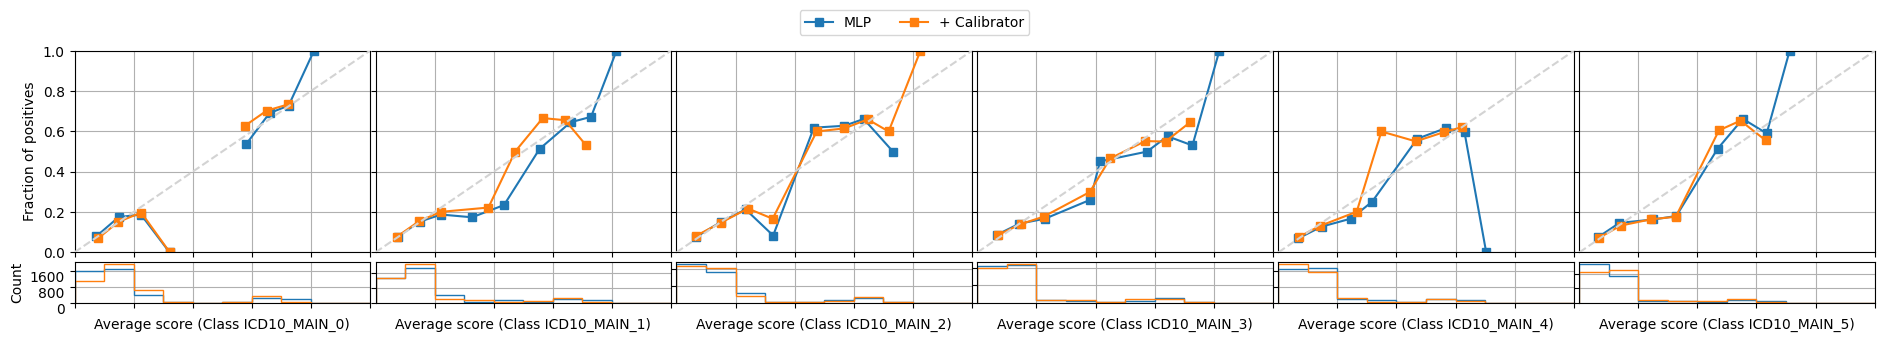

In [51]:
# 1) get your raw logits from the MLP
props_val  = model.predict_proba(ds_val.X)   # shape (n_val, n_classes)
probs_test = model.predict_proba(ds_test.X)  # shape (n_test, n_classes)

# 2) instantiate & fit the pycalib logistic (Platt) calibrator
calibrator = LogisticCalibration(
    C=1.0,
    solver='lbfgs',
    multi_class='multinomial',
    log_transform=True
)
calibrator.fit(props_val, y_val)

# 3) use it to get calibrated probabilities on your test set
probs_calibrated = calibrator.predict_proba(probs_test)  # shape (n_test, n_classes)

_ = plot_reliability_diagram(
    ds_test.y.numpy(),
    [probs_test, probs_calibrated],
    legend=["MLP", "+ Calibrator"],
    class_names=list(ds_test.classes),
)

for metric in ECE, conf_ECE, classwise_ECE:
    print(metric.__name__)
    print("Classifier = {:.3f}".format(metric(ds_test.y.numpy(), probs_test, bins=15)))
    print("Calibrator = {:.3f}".format(metric(ds_test.y.numpy(), probs_calibrated, bins=15)))
    print("")

[explains ECE and nessesary binning](https://towardsdatascience.com/expected-calibration-error-ece-a-step-by-step-visual-explanation-with-python-code-c3e9aa12937d/)

In [ ]:
cal = CalibratedClassifierCV(estimator=model, method="sigmoid", cv="prefit")
cal.fit(ds_val.X.numpy(), ds_val.y.numpy())

scores_cal = cal.predict_proba(ds_test.X)

_ = plot_reliability_diagram(
    ds_test.y.numpy(),
    [test_probs.numpy(), scores_cal],
    legend=["MLP", "+ Calibrator"],
    class_names=list(ds_test.classes),
)

In [7]:

# 1) pull out your arrays from the Dataset
#    (they’re already torch.Tensors of shape [n_samples, n_features])
X_train = ds_train.X.cpu().numpy()
y_train = ds_train.y.cpu().numpy()
X_val = ds_val.X.cpu().numpy()
y_val = ds_val.y.cpu().numpy()
X_test = ds_test.X.cpu().numpy()
y_test = ds_test.y.cpu().numpy()

# 2) instantiate the sklearn‐wrapped MLP
mlp = sklearnMLP(
    input_dim=X_train.shape[1],  # number of columns in X_train
    hidden_dim=128,  # pick whatever you like
    num_classes=len(ds_train.classes),  # your LabelEncoder’s classes
    batch_size=64,
    num_epochs=20,
    learning_rate=1e-3,
    early_stopping_patience=5,
    device="cpu",  # or "cuda" if you like
    verbose=True,
)

# 3) fit on your training set
mlp.fit(X_train, y_train)

Epoch 1/20, Loss=1.6020, F1=0.4356
Epoch 2/20, Loss=1.5225, F1=0.4375
Epoch 3/20, Loss=1.5160, F1=0.4406
Epoch 4/20, Loss=1.5139, F1=0.4401
Epoch 5/20, Loss=1.5071, F1=0.4412
Epoch 6/20, Loss=1.5055, F1=0.4424
Epoch 7/20, Loss=1.5042, F1=0.4424
Epoch 8/20, Loss=1.5046, F1=0.4416
Epoch 9/20, Loss=1.5038, F1=0.4433
Epoch 10/20, Loss=1.5035, F1=0.4422
Epoch 11/20, Loss=1.5011, F1=0.4410
Epoch 12/20, Loss=1.5001, F1=0.4426
Epoch 13/20, Loss=1.4993, F1=0.4447
Epoch 14/20, Loss=1.4997, F1=0.4418
Epoch 15/20, Loss=1.4996, F1=0.4442
Epoch 16/20, Loss=1.4972, F1=0.4429
Epoch 17/20, Loss=1.4974, F1=0.4422
Early stopping at epoch 18


sklearnMLP(batch_size=64, dropout=Dropout(p=0.2, inplace=False),
           early_stopping_patience=5, hidden_dim=128, input_dim=108,
           num_classes=6, num_epochs=20)

In [8]:
# 4) calibrate on the validation set
cal = CalibratedClassifierCV(estimator=mlp, method="sigmoid", cv="prefit")
cal.fit(X_val, y_val)

# 5) now you can predict or get calibrated probabilities
probs_test_uncal = mlp.predict_proba(X_test)  # raw MLP probs
probs_test_cal = cal.predict_proba(X_test)  # after sigmoid‐calibration

c:\Users\Lwsja\GitHub\uncertainty-aware-diagnosis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


ValueError: sklearnMLP should either be a classifier to be used with response_method=['decision_function', 'predict_proba'] or the response_method should be 'predict'. Got a regressor with response_method=['decision_function', 'predict_proba'] instead.

In [6]:
from uncertainty_aware_diagnosis import SklearnWrapper
from sklearn.frozen import FrozenEstimator

In [7]:

# pull out your arrays
X_train, y_train = ds_train.X.numpy(), ds_train.y.numpy()
X_val,   y_val   = ds_val.X.numpy(),   ds_val.y.numpy()
X_test,  y_test  = ds_test.X.numpy(),  ds_test.y.numpy()

# wrap it
sk_mlp = SklearnWrapper(
    input_dim   = X_train.shape[1],
    hidden_dim  = 128,
    num_classes = len(ds_train.classes),
    batch_size  = 64,
    num_epochs  = 20,
    learning_rate = 1e-3,
    device      = "cpu",    # or "cuda"
    verbose     = True,
)

# 1) fit
sk_mlp.fit(X_train, y_train)


Epoch 1/20, Train Loss: 1.5889, Val Loss: 1.5034, F1 Macro: 0.4372, Recall Macro: 0.4349
Epoch 2/20, Train Loss: 1.5213, Val Loss: 1.4979, F1 Macro: 0.4393, Recall Macro: 0.4388
Epoch 3/20, Train Loss: 1.5161, Val Loss: 1.4933, F1 Macro: 0.4395, Recall Macro: 0.4379
Epoch 4/20, Train Loss: 1.5128, Val Loss: 1.4921, F1 Macro: 0.4401, Recall Macro: 0.4387
Epoch 5/20, Train Loss: 1.5097, Val Loss: 1.4916, F1 Macro: 0.4407, Recall Macro: 0.4394
Epoch 6/20, Train Loss: 1.5089, Val Loss: 1.4896, F1 Macro: 0.4423, Recall Macro: 0.4398
Epoch 7/20, Train Loss: 1.5047, Val Loss: 1.4888, F1 Macro: 0.4437, Recall Macro: 0.4428
Epoch 8/20, Train Loss: 1.5044, Val Loss: 1.4885, F1 Macro: 0.4432, Recall Macro: 0.4420
Epoch 9/20, Train Loss: 1.5053, Val Loss: 1.4873, F1 Macro: 0.4431, Recall Macro: 0.4404
Epoch 10/20, Train Loss: 1.5025, Val Loss: 1.4868, F1 Macro: 0.4426, Recall Macro: 0.4407
Epoch 11/20, Train Loss: 1.5022, Val Loss: 1.4869, F1 Macro: 0.4435, Recall Macro: 0.4417
Epoch 12/20, Train 

SklearnWrapper(batch_size=64, hidden_dim=128, input_dim=108, num_classes=6,
               num_epochs=20, verbose=True)

In [8]:
# 2) calibrate
cal = CalibratedClassifierCV(sk_mlp, method="sigmoid", cv="prefit")
cal.fit(X_val, y_val)

# 3) now you can do
probs_uncal = sk_mlp.predict_proba(X_test)
probs_cal   = cal.predict_proba(X_test)

c:\Users\Lwsja\GitHub\uncertainty-aware-diagnosis\.venv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


ValueError: SklearnWrapper should either be a classifier to be used with response_method=['decision_function', 'predict_proba'] or the response_method should be 'predict'. Got a regressor with response_method=['decision_function', 'predict_proba'] instead.

In [ ]:
_ = plot_reliability_diagram(
    ds_test.y.numpy(),
    [probs_test_uncal, probs_test_cal],
    legend=["MLP", "+ Calibrator"],
    class_names=list(ds_test.classes),
)